<a href="https://colab.research.google.com/github/arimaz1881/ML-Exercises/blob/master/Transformer_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing basic Transformer architecture by this scheme

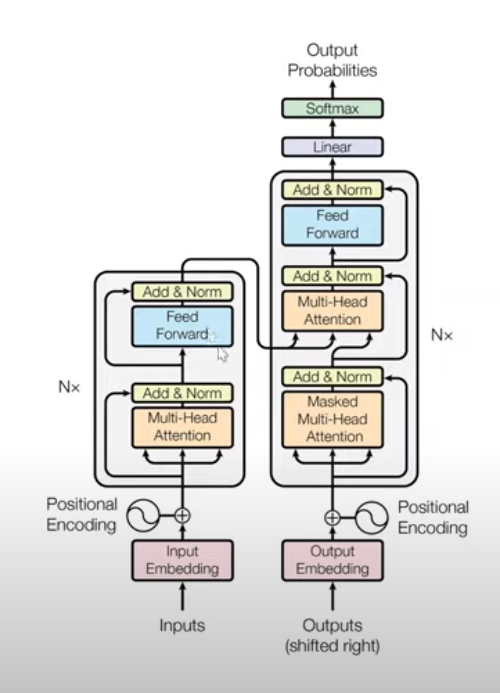

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model}$ = 512.

In [ ]:
import torch
import torch.nn as nn
import math


class InputEmbeddings(nn.Module):
    '''making embedding is mapping between number and a vector of given dimentionality'''

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model   # d_model - dimention of embedding
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


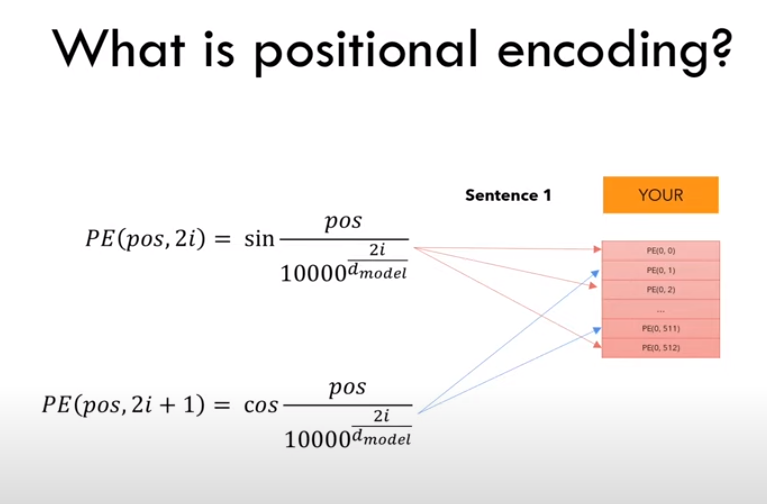

Layer Normalization block\
$\hat{x}_j = \frac{{x_j - \mu_j}}{{\sqrt{{\sigma_j^2 + \epsilon}}}}$

where:


*   $\hat{x}_j$ is Transformed value of the input feature at index $j$.
*   ${x}_j$ is Original value of the input feature at index $j$.
*   ${\mu_j}$ is Mean of the input feature.
*   ${\sigma_j^2}$ is Squared standard deviation of the input feature.
*   ${\epsilon}$ is Small term for computational stability, added to avoid division by zero.



In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float=10**-6):
        super().__init__()
        self.eps = eps
        # initialize learnable params
        self.alpha = nn.Parameter(torch.ones(1)) # Multiplied (weights)
        self.bias = nn.Parameter(torch.zeros(1)) # Added (biases)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

Feed Forward Block

$FFN(x) = max(0, xW_1+b_1)W_2+b_2$

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.



In [ ]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        '''params:
        d_ff - inner-layer feedforward dimentionality
        d_model - dimentionality of embeddings'''
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Dimentions transformations through this layer:
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_ff) --> (batch_size, seq_len, d_model)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Attention layer

Linear layers can be used for purposes such as:


1.   Mapping inputs into the outputs
2.   Changing matrix/vector dimensions

The larger the vector, the more operations it requires, so typically we want to shrink dimentionality of embedding layers

Attention system has 3 separate linear layers, each of those encode Query, Key and Value. Когда мы проходимся аттеншном по каждому слову, каждое слово представляет собой Query, этот Куери нужен чтобы найти самые схожие (similar) слова по контексту, которые представляют собой набор Ключей (Keys). Слова с самыми схожими Keys возвращают свой Value.

### Similarity Score

Чтобы посчитать схожесть (similarity) векторов, используется Cosine similarity. It scales from -1 to 1, where -1 means that the vectors are pointing in the opposite directions and 1 means that they are pointing in the same directions.
So, cosine similarity считает косинус угла между сравниваемыми векторами, где cos(0°) = 1, а cos(180°) = -1

Другой способ посчитать cosine similarity, который и будет реализовываться в коде:

$cos(Q,K)=\frac{(Q*K^T)}{(|Q|*|K|)}$
where:

*   $K^T$ is Key (transposed to avoid conflicts in dimentions during matrix multiplication)
*   $Q$ is Query

In Attention filter computation, we calculate matrix multiplication as ${(Q*K^T)}$ part and ${(|Q|*|K|)}$ part is represented by scaling by $\sqrt{d_{model}}$

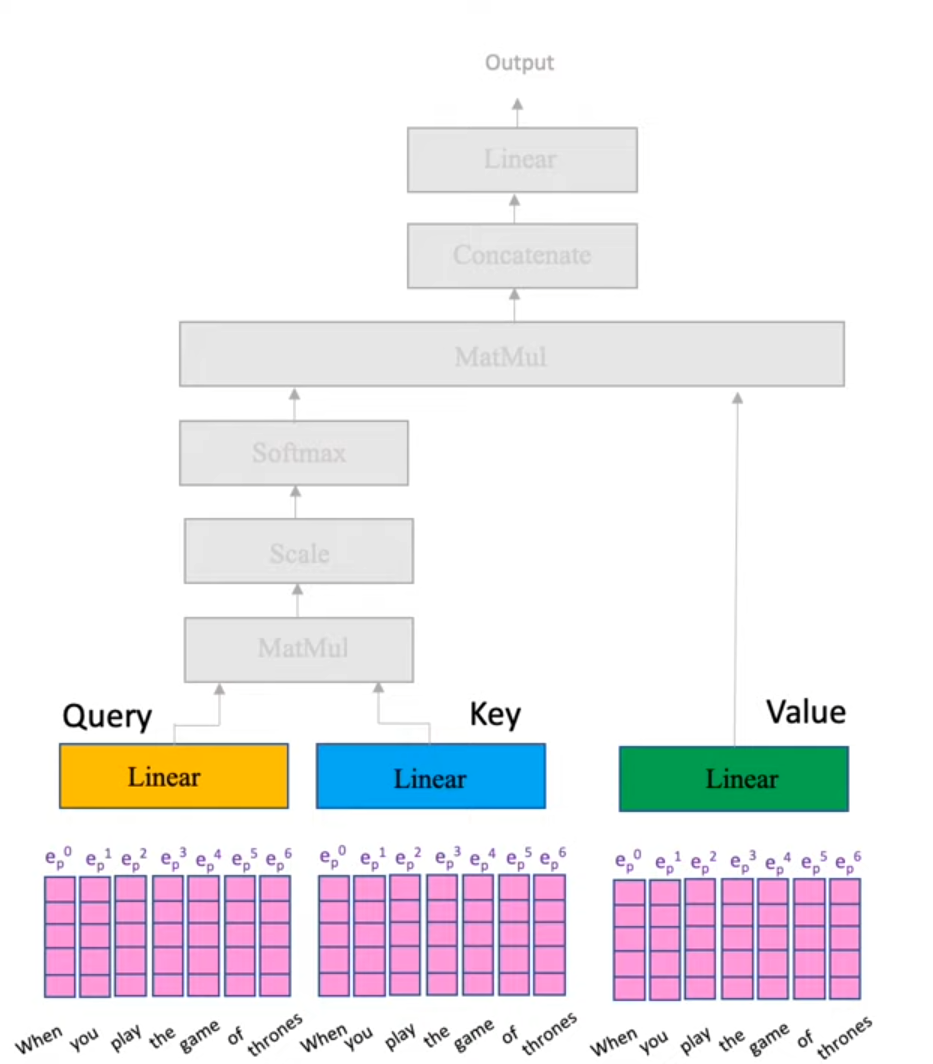


Query, Key and Value layers are fed by the same position-aware embeddings, that we got in previous steps

At the first step, outputs of Query and Key layers are multiplied and form Attention filter

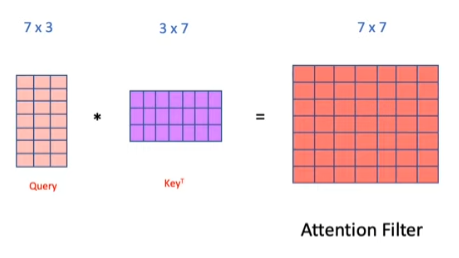

At first, Attention filter doesn't have any sense, but after training it gains meaning, where more related words have more similarity scores

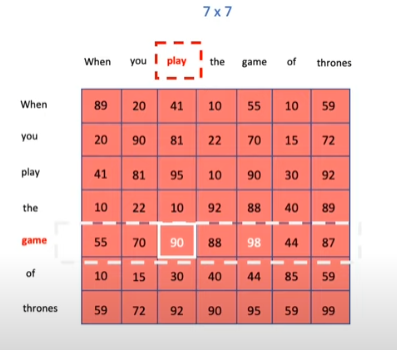

Then authors of the paper scaled the values inside the Attention filter by $\sqrt{d_{model}}$ (hidden dimension of the Key matrix) and then squash numbers between 0 and 1 by Softmax.

Final attention filter looks something like this:
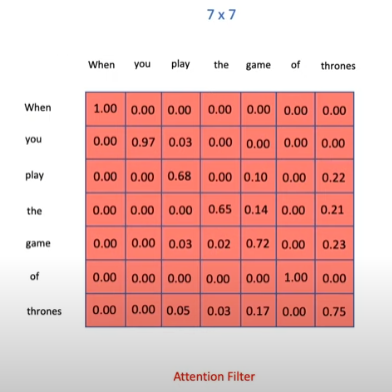

So, the overall formula for the Attention filter is:

$softmax(\frac{Q*K^T}{\sqrt{d_{model}}})$

When we multiply Attention Filter by the Original Context Matrix (which we got from Value Layer) we get a filtered representation of context, that has more weight on important parts of the input and less weight on unimportant

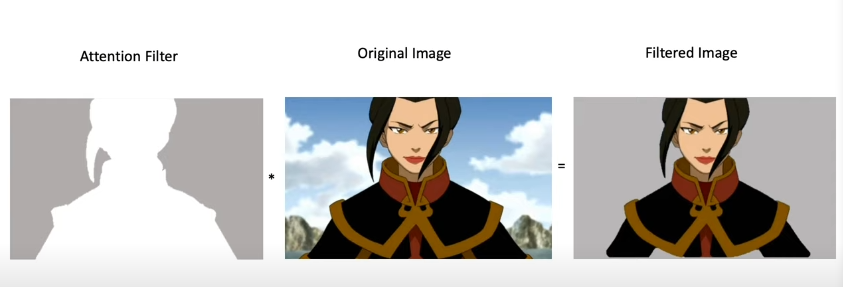


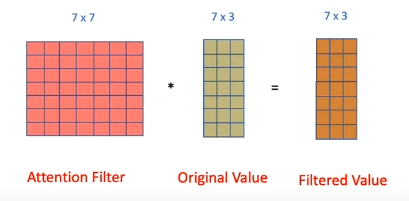

This filtered value matrix is the final output of the Attention Layer:

$Attention(Q,K,V)=softmax(\frac{Q*K^T}{\sqrt{d_{model}}})*V$

where $V$ is output matrix from Value Layer

However, we have several attention filters that concentrate their focus on different parts of the input

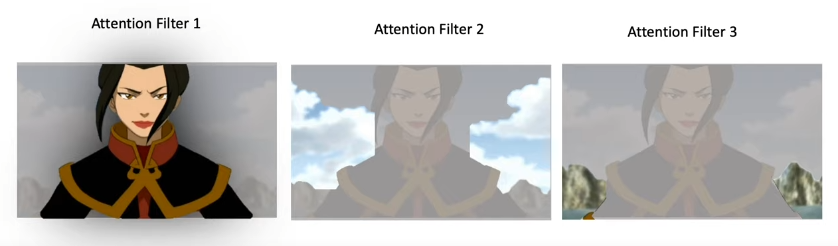

Transformers learn multiple Attention Fiilters, each focusing on different linguistic phenomena

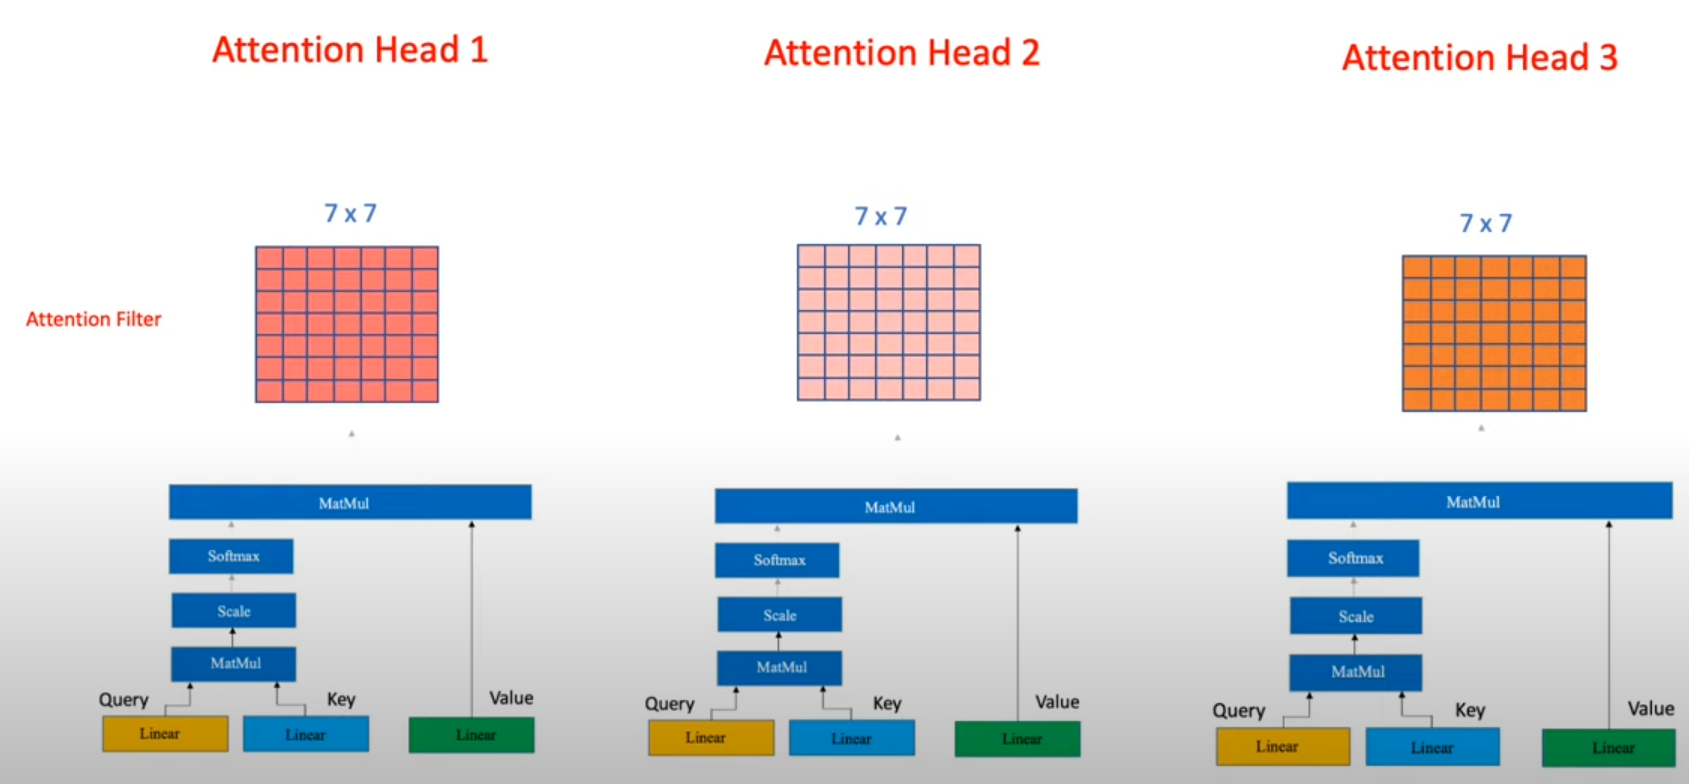

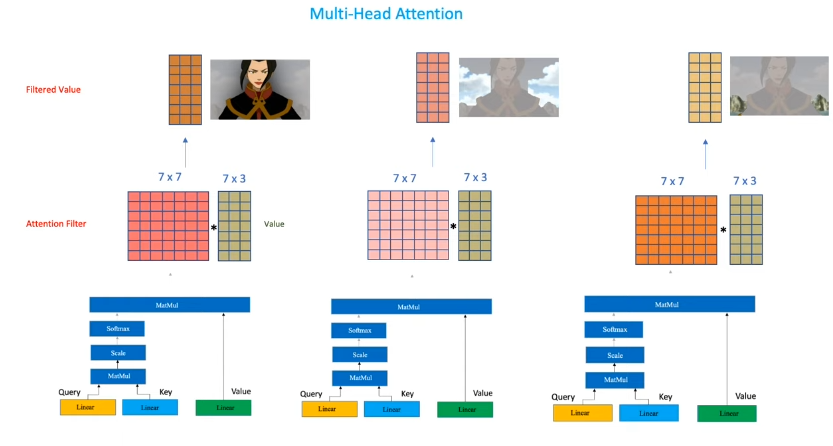

Next, we concatenate outputs of all Attention heads and pass through Linear layer to shrink dimentionality

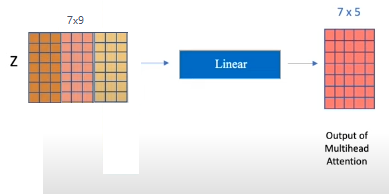

In MultiHead Attention we use $d_k$ rather than $d_{model}$ which is:

$d_k=\frac{d_{model}}{h}$

In attention mechanisms, particularly in models like Transformers, the concept of "attention heads" is used to allow the model to attend to different parts of the input sequence simultaneously and capture different types of relationships or patterns within the data. Each attention head learns its own attention weights, which are then combined to produce the final representation.

In [ ]:
class MultiheadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout_rate: float):
        """params:
        d_model - hidden layers dimention
        h - number of heads of multihead attention"""

        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        # inner dimention of each attentioin head
        self.d_k = d_model // h
        # parameter matrices for Query, Key and Value
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        # output matrix after concatenating attention outputs
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask):
        """params:
        q - embeddings for query
        k - embeddings for key
        v - embeddings for value
        mask -
         """
        query = self.w_q(q) # dimentions (batch_size, seq_len, d_model)
        key = self.w_k(k)
        value = self.w_v(v)
        # splitting embeddings into different attention heads
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, h, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k)
        # (batch_size, seq_len, h, d_k) --> (batch_size, h, seq_len, d_k)
        # we transpose because we want attention to be of (seq_len, d_k) matrices
        query = query.transpose(1, 2)

        # same thing for key and value
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
